#Descrição do Problema MNIST da Linguagem de Sinais (American Sign Language)
A American Sign Language (ASL) é uma linguagem completa e natural que possui as mesmas propriedades linguísticas das línguas faladas, com gramática diferente do inglês. A ASL é expressa por movimentos das mãos e do rosto. É o idioma principal de muitos norte-americanos surdos e com deficiência auditiva, e é usado por muitas pessoas ouvintes também.
O formato do conjunto de dados é padronizado para coincidir com o MNIST clássico. Cada caso de treinamento e teste representa um rótulo (0-25) como um mapa individual para cada letra alfabética A-Z (e nenhum caso para 9 = J ou 25 = Z por causa dos movimentos dos gestos). Os dados de treinamento (27.455 casos) e os dados de teste (7172 casos) são aproximadamente metade do tamanho do MNIST padrão, mas são semelhantes a uma linha de cabeçalho de rótulo, pixel1, pixel2… .pixel784, que representa uma única imagem de 28x28 pixels com valores de escala de cinza entre 0-255. 

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# Any results you write to the current directory are saved as output.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# carregando as imagens

In [4]:
train_df = pd.read_csv("chiga/sign_mnist_train.csv")
test_df = pd.read_csv("chiga/sign_mnist_test.csv")

In [5]:
test = pd.read_csv("chiga/sign_mnist_test.csv")
y = test['label']

#cade as imagens professor?? São pixels numero de 0 a 784 28*28

In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


# vamos visualizar um pouco

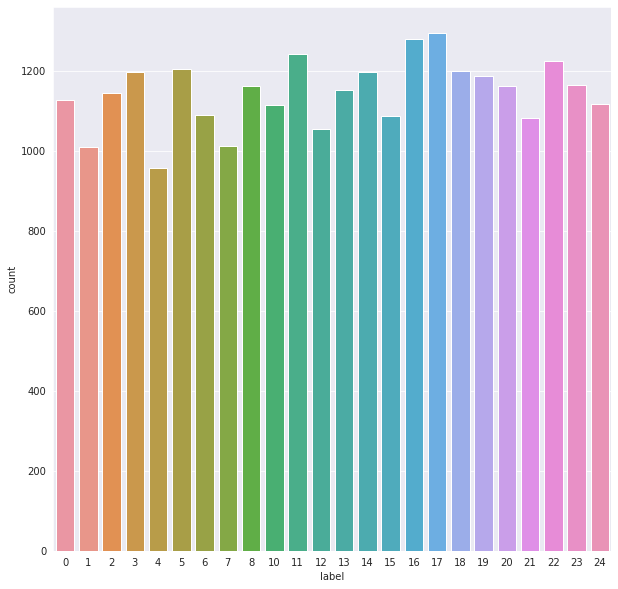

In [7]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

** O conjunto de dados parece equilibrado quanto a cada rótulo de treinamento, existem exemplos suficientes de treinamento **

In [8]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [10]:
x_train = train_df.values
x_test = test_df.values

** Realizamos uma normalização em escala de cinza para reduzir o efeito das diferenças de iluminação. Além disso, a CNN converge mais rapidamente em dados [0..1] do que em [0..255]. **

In [11]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [12]:
# Remodelagem dos dados de 1-D para 3-D, conforme exigido pela entrada das CNNs
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**as 10 primeiras imagens**

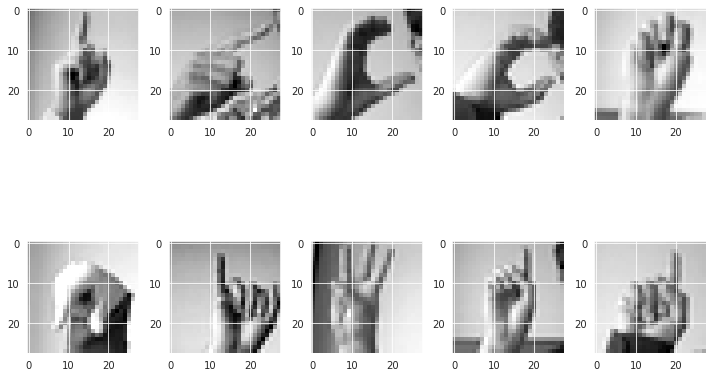

In [13]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

# REDES NEURAIS CONVOLUCIONAIS PARA O SALVAMENTO
** Uma Rede Neural Convolucional é um tipo especial de implementação de Inteligência Artificial que usa uma manipulação matemática matricial especial chamada operação de convolução para processar dados das imagens. **

* ** Uma convolução faz isso multiplicando duas matrizes e produzindo uma terceira matriz menor. **
* ** A rede obtém uma imagem de entrada e usa um filtro (ou kernel) para criar um mapa de recursos descrevendo a imagem. **
* ** Na operação de convolução, pegamos um filtro (geralmente matriz 2x2 ou 3x3) e deslizamos sobre a matriz da imagem. Os números de correspondência de cores em ambas as matrizes são multiplicados e adicionados para gerar um único número que descreve esse espaço de entrada. Esse processo é repetido em toda a imagem. Esse trabalho pode ser visto na figura a seguir **
![image.png](attachment:image.png)

# Entrenando el modelo

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [15]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)         

In [16]:
history = model.fit(x_train,y_train, batch_size = 128 ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Train on 27455 samples, validate on 7172 samples
Epoch 1/1
27455/27455 [==============================] - 14s 504us/step - loss: 0.4983 - accuracy: 0.8558 - val_loss: 3.2358 - val_accuracy: 0.1107


In [17]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

7172/7172 [==============================] - 1s 127us/step
Accuracy of the model is -  11.07083112001419 %


# Análise após o treinamento do modelo

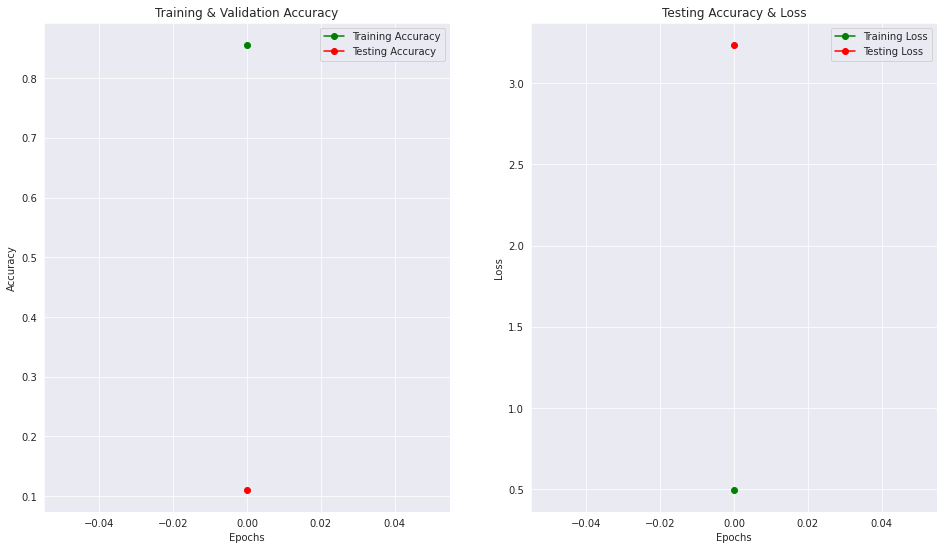

In [19]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [20]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
print (predictions[:20],np.argmax(y_test[:20],1))        

[ 7  7 10  7 20  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7] [ 6  5  9  0  3 20  9 13  3  7  8  8 20 11  7  4 21  0  7  7]


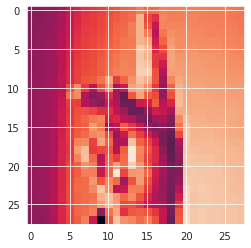

In [21]:
import matplotlib.pyplot as plt
plt.imshow(x_test[2,:,:,0])

In [22]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       331
     Class 1       0.61      0.08      0.14       432
     Class 2       0.00      0.00      0.00       310
     Class 3       0.00      0.00      0.00       245
     Class 4       0.00      0.00      0.00       498
     Class 5       0.00      0.00      0.00       247
     Class 6       0.57      0.34      0.43       348
     Class 7       0.07      1.00      0.13       436
     Class 8       1.00      0.00      0.01       288
    Class 10       1.00      0.08      0.16       331
    Class 11       0.00      0.00      0.00       209
    Class 12       0.00      0.00      0.00       394
    Class 13       0.89      0.20      0.33       291
    Class 14       0.00      0.00      0.00       246
    Class 15       0.00      0.00      0.00       347
    Class 16       0.00      0.00      0.00       164
    Class 17       1.00      0.01      0.03       144
    Class 18       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
cm = confusion_matrix(y,predictions)

In [24]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

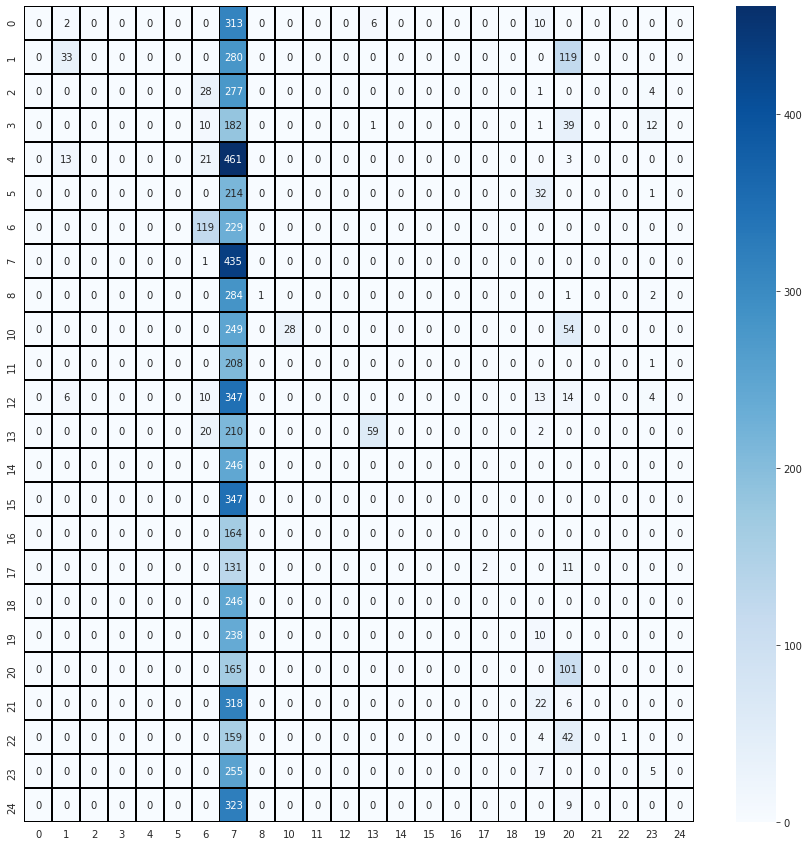

In [25]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

** Algumas das classes corretamente previstas **